In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-24 19:03:51.772035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:03:51.772323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:03:51.880055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 19:03:52.071136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 19:03:53.418030: W tensorflow/compiler/tf2

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [2]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


2024-04-24 19:03:56.196202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 19:03:56.196440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 19:03:56.196574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель ResNet50V2 без верхних слоев:

In [3]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(256, 256, 3),
                                              include_top=False,
                                              weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [4]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [5]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                             

Начнем обучение модели с замороженными нижними слоями:

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [8]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/resnet_50_v2.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [9]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


2024-04-24 19:04:03.364510: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 19:04:03.569913: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 19:04:06.136903: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-04-24 19:04:07.617718: I external/local_xla/xla/service/service.cc:168] XLA service 0x7845848ec3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Dev

433/433 [==============================] - 72s 149ms/step - loss: 2.5097 - accuracy: 0.3299 - val_loss: 1.6609 - val_accuracy: 0.5577
Epoch 2/20
433/433 [==============================] - 62s 142ms/step - loss: 1.6496 - accuracy: 0.5362 - val_loss: 1.3533 - val_accuracy: 0.6239
Epoch 3/20
433/433 [==============================] - 62s 143ms/step - loss: 1.3744 - accuracy: 0.6070 - val_loss: 1.2126 - val_accuracy: 0.6512
Epoch 4/20
433/433 [==============================] - 62s 144ms/step - loss: 1.2114 - accuracy: 0.6500 - val_loss: 1.1498 - val_accuracy: 0.6718
Epoch 5/20
433/433 [==============================] - 62s 143ms/step - loss: 1.1148 - accuracy: 0.6770 - val_loss: 1.0900 - val_accuracy: 0.6901
Epoch 6/20
433/433 [==============================] - 63s 144ms/step - loss: 1.0112 - accuracy: 0.7055 - val_loss: 1.0380 - val_accuracy: 0.7002
Epoch 7/20
433/433 [==============================] - 63s 144ms/step - loss: 0.9416 - accuracy: 0.7273 - val_loss: 1.0213 - val_accuracy: 0.7

Так как число параметров в нижних слоях огромно (более 23 миллионов), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [10]:
results = model.evaluate(test_ds)

93/93 [==============================] - 11s 111ms/step - loss: 0.9102 - accuracy: 0.7413


In [11]:
results

[0.9102302193641663, 0.7412634491920471]

Посомтрим несколько предсказаний:

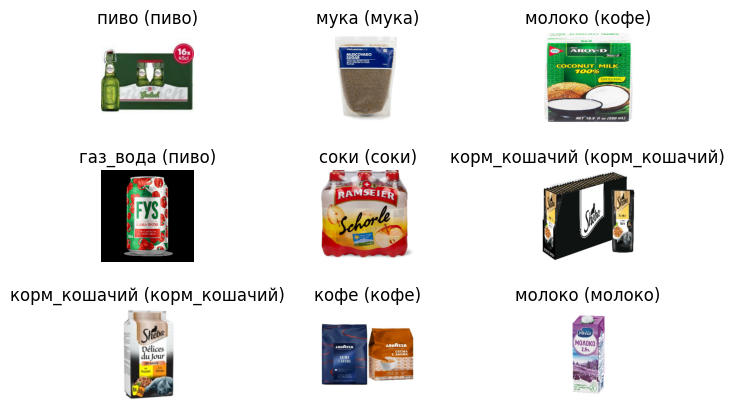

In [12]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


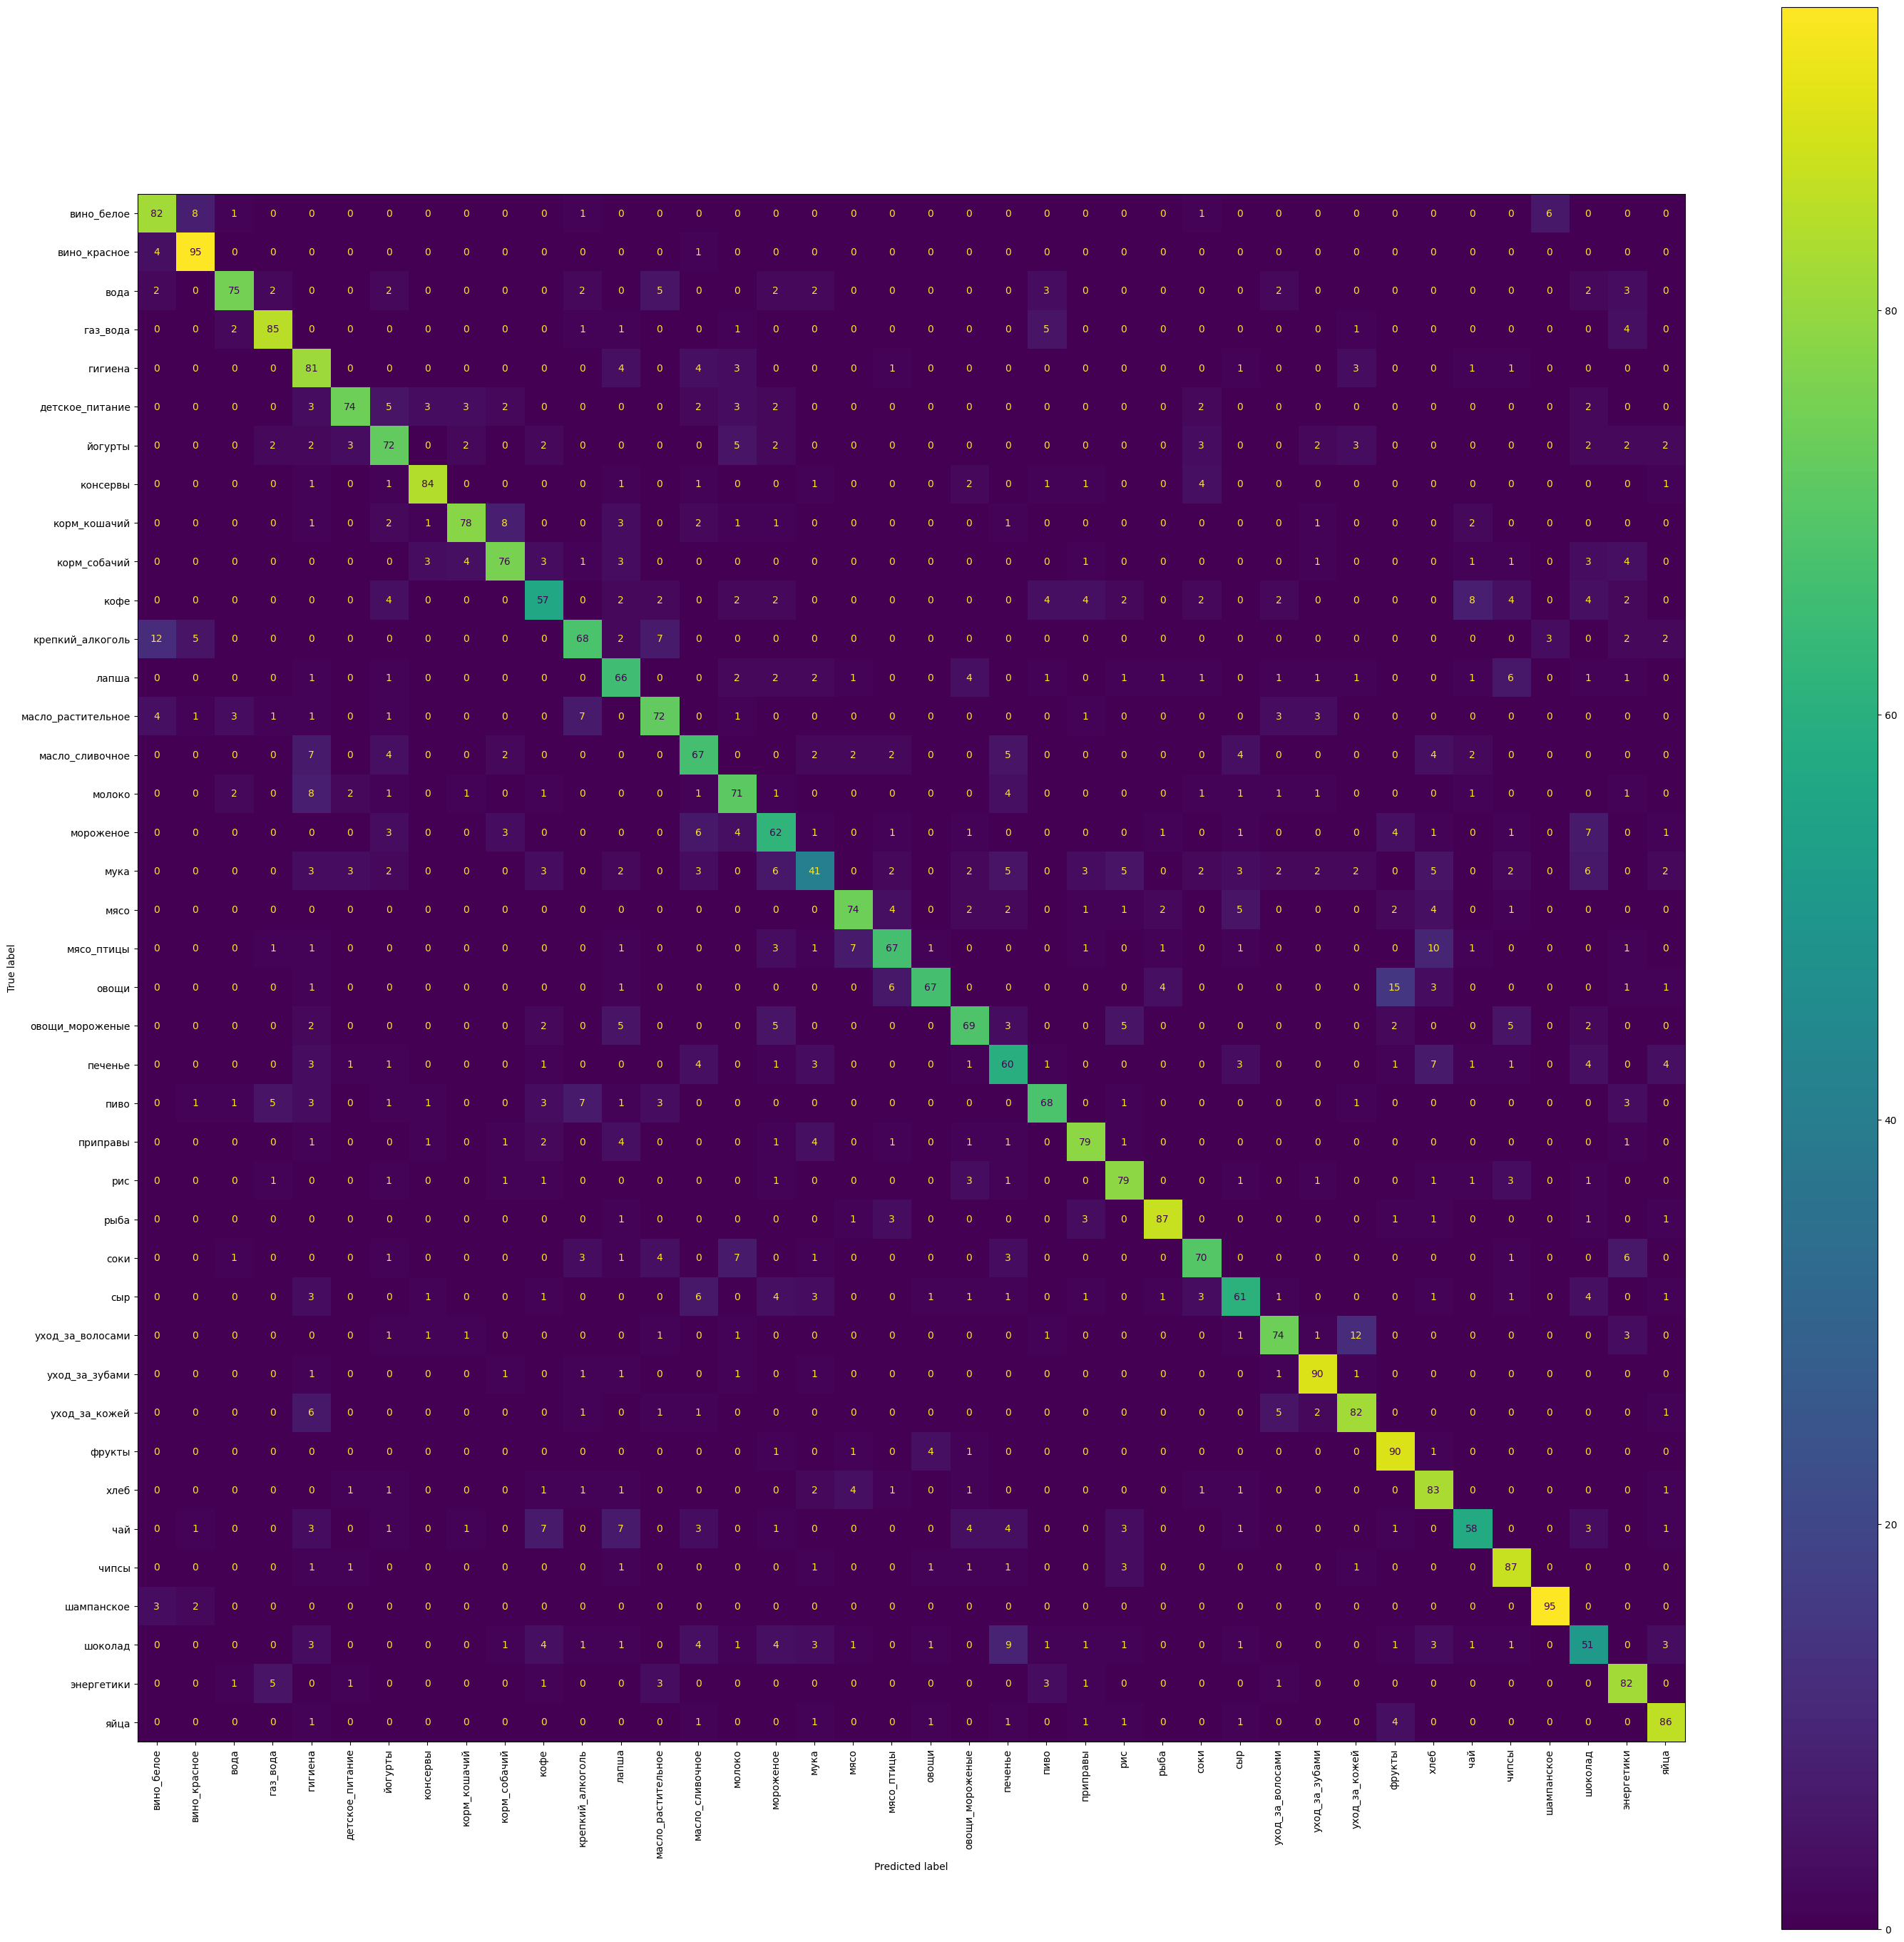

In [13]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [14]:
model.save('ready_models/resnet_50_v2.keras')

In [15]:
import json

with open('models_histories/resnet_50_v2.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

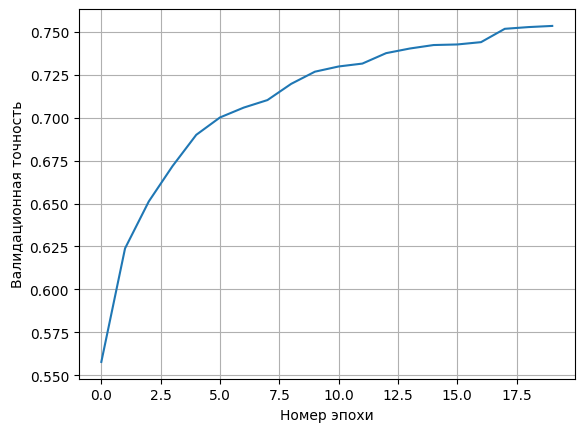

In [16]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')